# Projet Pacte : Maintenance Prédictive
Le projet de Maintenance Prédictive consiste à anticiper les défaillances potentielles des machines industrielles avant qu'elles ne surviennent, permettant ainsi une gestion proactive et plus efficace des opérations. L'objectif principal est de prédire la probabilité qu'une machine tombe en panne et de déterminer quel type de panne pourrait se produire, ce qui permet de planifier les interventions de maintenance de manière optimale et de minimiser les temps d'arrêt non planifiés.

### 1. Objectifs du projet :
- Prédiction de la panne (classification binaire) : Identifier si une machine tombera en panne ou non à un moment donné.
- Prédiction du type de panne (classification multi-classe) : Identifier le type spécifique de panne qui pourrait se produire (par exemple, panne de puissance, panne mécanique, etc.).

Les données utilisées pour ce projet sont fournies par l'UCI dans le cadre d'un dataset de maintenance prédictive. Ce dataset contient des informations provenant de diverses machines, avec des mesures de différents paramètres liés à la performance des machines, comme la température, la vitesse de rotation, le couple, l'usure des outils, etc. Ces paramètres permettent de modéliser et de prévoir les pannes.

### Le dataset est constitué des colonnes suivantes :

- UDI : Identifiant unique de la machine.
- Product ID : Identifiant du produit/machine.
- Type : Type de la machine (M, L, H).
- Air temperature [K] : Température de l'air en Kelvin.
- Process temperature [K] : Température du processus en Kelvin.
- Rotational speed [rpm] : Vitesse de rotation de la machine (en tours par minute).
- Torque [Nm] : Couple appliqué sur la machine (en Newton-mètre).
- Tool wear [min] : Usure de l'outil en minutes.
- Target : La variable cible, indiquant si une panne a eu lieu (0 = pas de panne, 1 = panne).
- Failure Type : Type de la panne (par exemple, "Power Failure", "Overheating", etc.).

### Variable cible
Pour la classification binaire : **Target**

Pour la classification multiclasse : **Failure Type**

In [732]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

### 2. Exploration et Préparation des Données
#### 2.1 Chargement et Analyse Initiale


In [733]:
# 1. Chargement des données
df = pd.read_csv("predictive_maintenance.csv")  # Remplace avec le vrai chemin du fichier

In [734]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [735]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [736]:
# Vérification des doublons
duplicates = df.duplicated()
print(f"\nNombre de doublons dans le dataset : {duplicates.sum()}")

# Suppression des doublons si nécessaire
df = df.drop_duplicates()
print(f"Nouvelle taille du dataset après suppression des doublons : {df.shape}")



Nombre de doublons dans le dataset : 0
Nouvelle taille du dataset après suppression des doublons : (10000, 10)


In [737]:
# suppression des colonnes inutiles
df.drop(['UDI', 'Product ID' ], axis=1, inplace=True)

In [738]:
# Separation des vaiables categoriques et numeriques
var_cat = ['Type', 'Failure Type', 'Target']
var_num = ['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

#### 2.2 Gestion des Données Manquantes et Anormales

In [739]:
# Données manquantes
df.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [740]:
# Détection des valeurs aberrantes avec la méthode IQR (Interquartile Range)
def detect_outliers_iqr(data, threshold=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return (data < lower_bound) | (data > upper_bound)

In [741]:
# Identification des valeurs aberrantes dans les variables numériques
outliers = df[var_num].apply(detect_outliers_iqr)
outlier_counts = outliers.sum()
print("\nNombre de valeurs aberrantes détectées par colonne :")
print(outlier_counts)


Nombre de valeurs aberrantes détectées par colonne :
Air temperature [K]          0
Process temperature [K]      0
Rotational speed [rpm]     418
Torque [Nm]                 69
Tool wear [min]              0
dtype: int64


Text(0.5, 1.0, 'Boxplot des variables numériques')

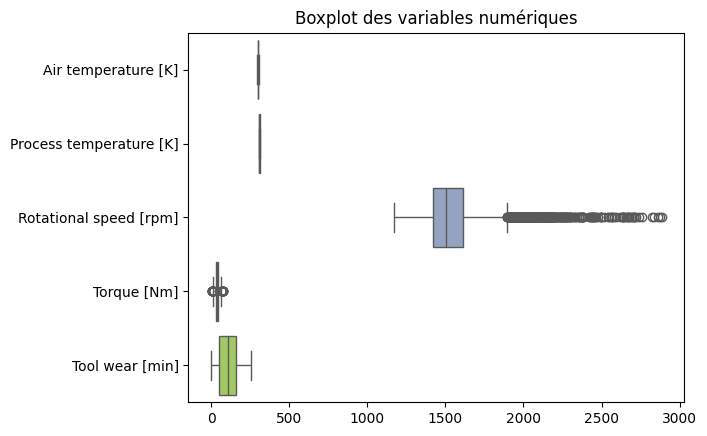

In [742]:
sns.boxplot(data=df[var_num], orient="h", palette="Set2")
plt.title("Boxplot des variables numériques")

On laisse les valeurs aberrantes parce que ces variables sont des mesures physiques

#### 2.3 Analyse Descriptive et Visualisation

In [743]:
# 3. Analyse descriptive
print("\nStatistiques descriptives :")
df.describe()


Statistiques descriptives :


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


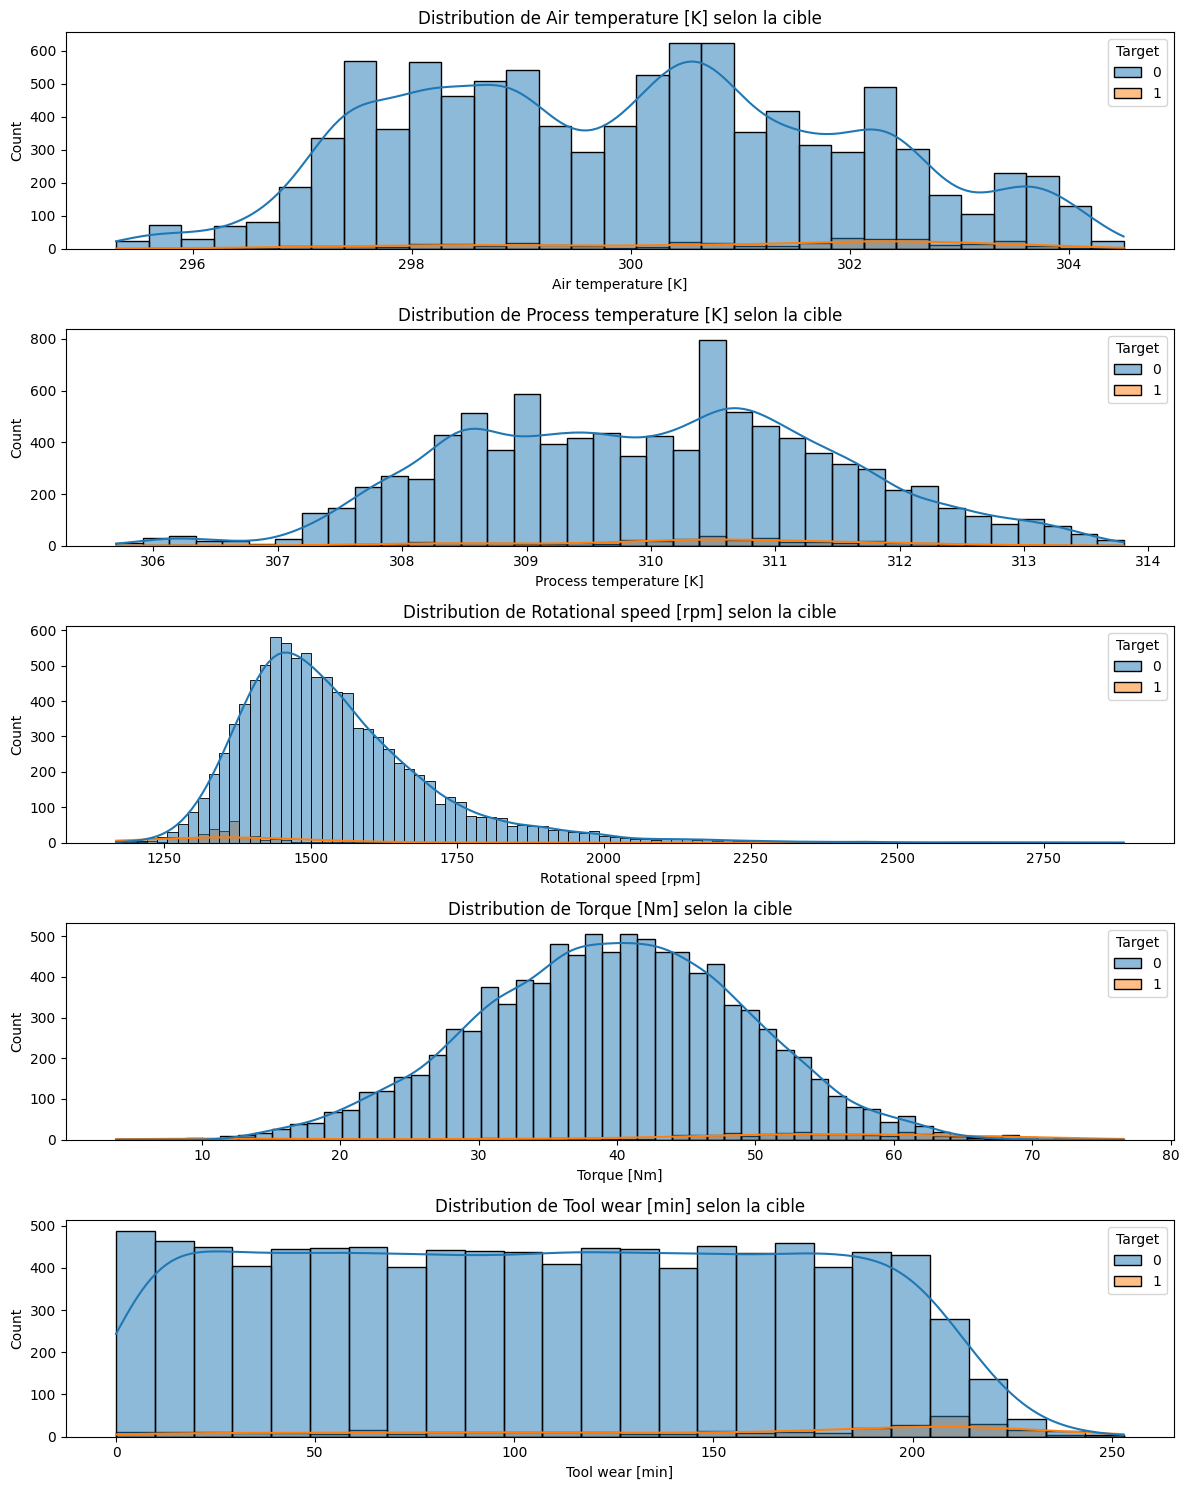

In [744]:
fig, axes = plt.subplots(nrows=len(var_num), figsize=(12, 15))
for i, feature in enumerate(var_num):
    sns.histplot(data=df, x=feature, hue='Target', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {feature} selon la cible')
plt.tight_layout()
plt.show()

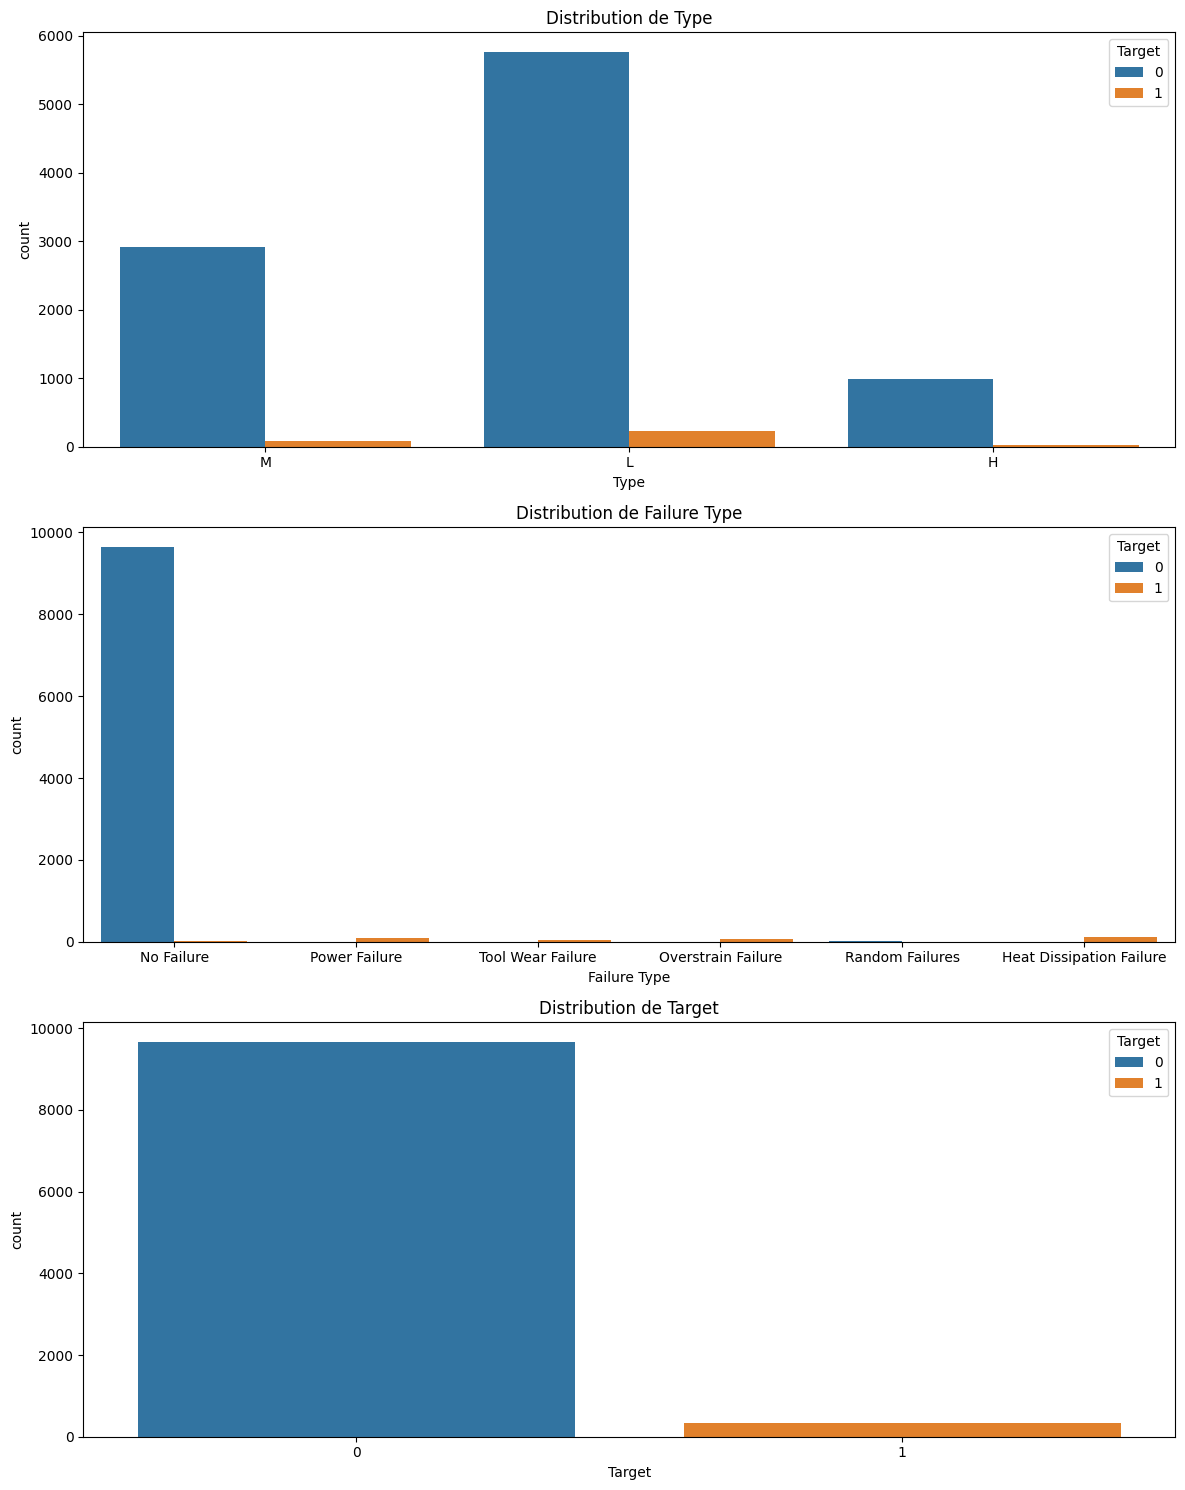

In [745]:
fig, axes = plt.subplots(nrows=len(var_cat), figsize=(12, 15))
for i, feature in enumerate(var_cat):
    sns.countplot(data=df, x=feature, hue='Target', ax=axes[i])
    axes[i].set_title(f'Distribution de {feature}')
plt.tight_layout()
plt.show()

Les classes des variables cibles sont très déséquilibrées. Necessite une équilibration

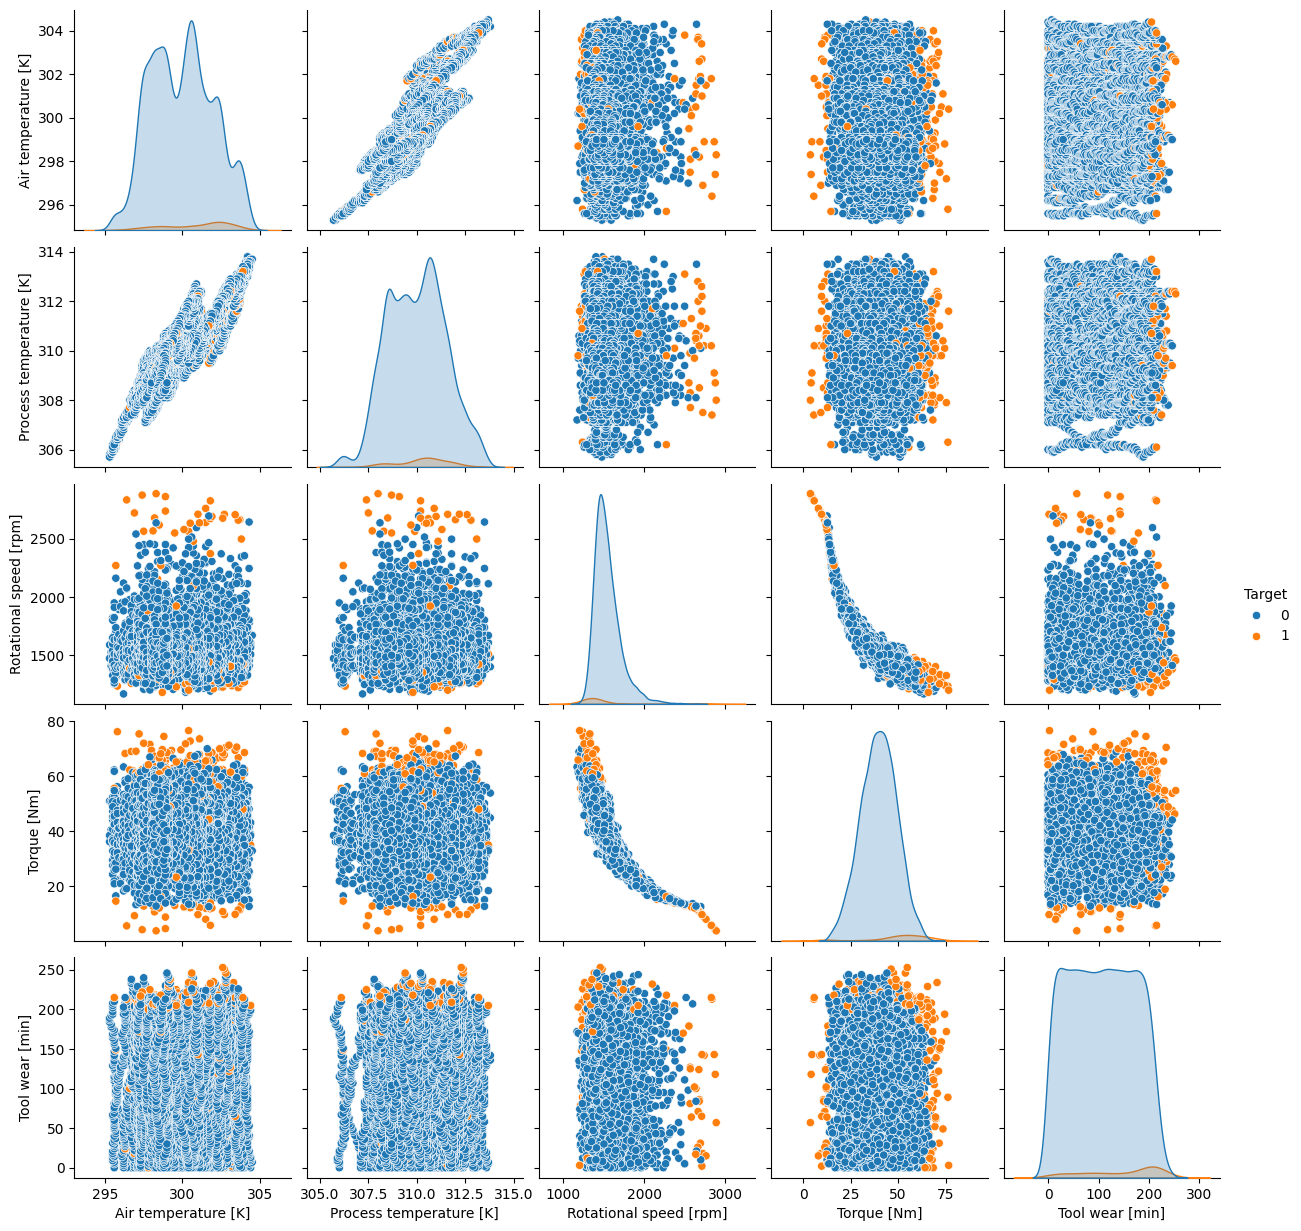

In [746]:
# 4. Visualisation des distributions
sns.pairplot(df, hue="Target")
plt.show()

In [747]:
# 5. Encodage des variables catégorielles avec One-Hot Encoding
df = pd.get_dummies(df, columns=["Type"], drop_first=True)

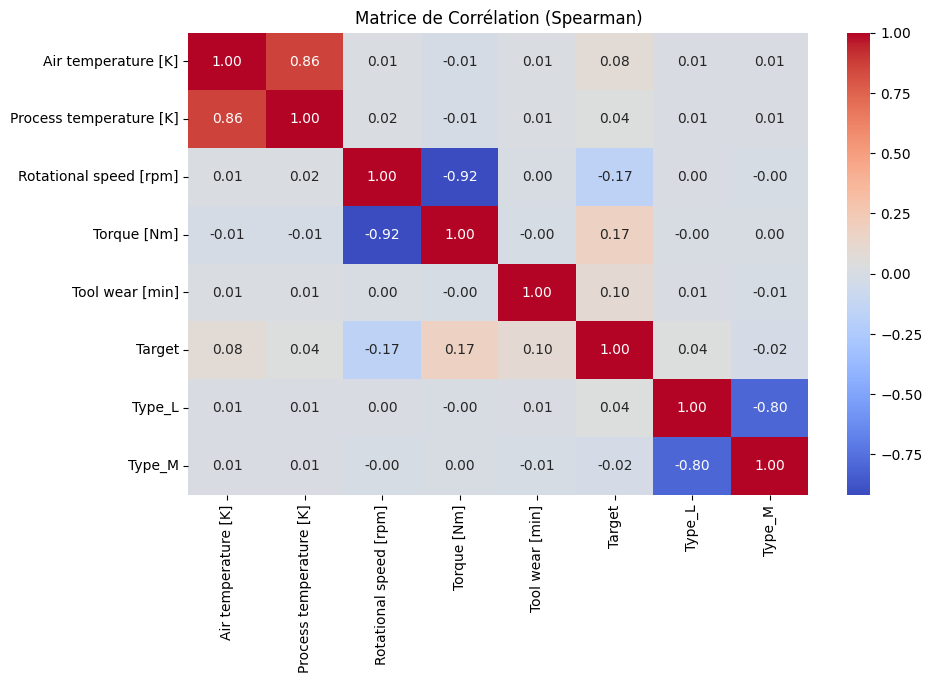

In [748]:
# 5. Matrice de corrélation (Spearman)
plt.figure(figsize=(10,6))
sns.heatmap(df[var_num + ["Target", "Type_L","Type_M"]].corr(method='spearman'), annot=True , cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation (Spearman)")
plt.show()

### 3. Stratégie de Gestion du Déséquilibre des Données



##### **SMOTE (Synthetic Minority Over-sampling Technique)**  
SMOTE est une technique de suréchantillonnage qui génère **de nouvelles instances synthétiques** pour la classe minoritaire en interpolant les exemples existants. Son but est de **rééquilibrer les classes** et d'éviter le surajustement causé par un simple duplicata des données.
##### **RandomOverSampler**  
RandomOverSampler est une méthode plus simple qui **duplique aléatoirement** les instances de la classe minoritaire jusqu'à obtenir un équilibre avec la classe majoritaire. Contrairement à SMOTE, il n’ajoute pas de nouvelles variations aux données.

In [749]:
# 7. Gestion des données déséquilibrées

X = df[["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]", "Type_L", "Type_M"]]
y_binaire = df["Target"]
y_multi = df["Failure Type"]

smote = SMOTE()
X_resampled_binaire, y_resampled_binaire = smote.fit_resample(X, y_binaire)

# Application de l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled_multi, y_resampled_multi = oversampler.fit_resample(X, y_multi)

C:\Users\atsou\AppData\Local\Temp\ipykernel_14944\500398555.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled_binaire, ax=axes[0], palette="Set2")
C:\Users\atsou\AppData\Local\Temp\ipykernel_14944\500398555.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled_multi,  ax=axes[1], palette="Set2")


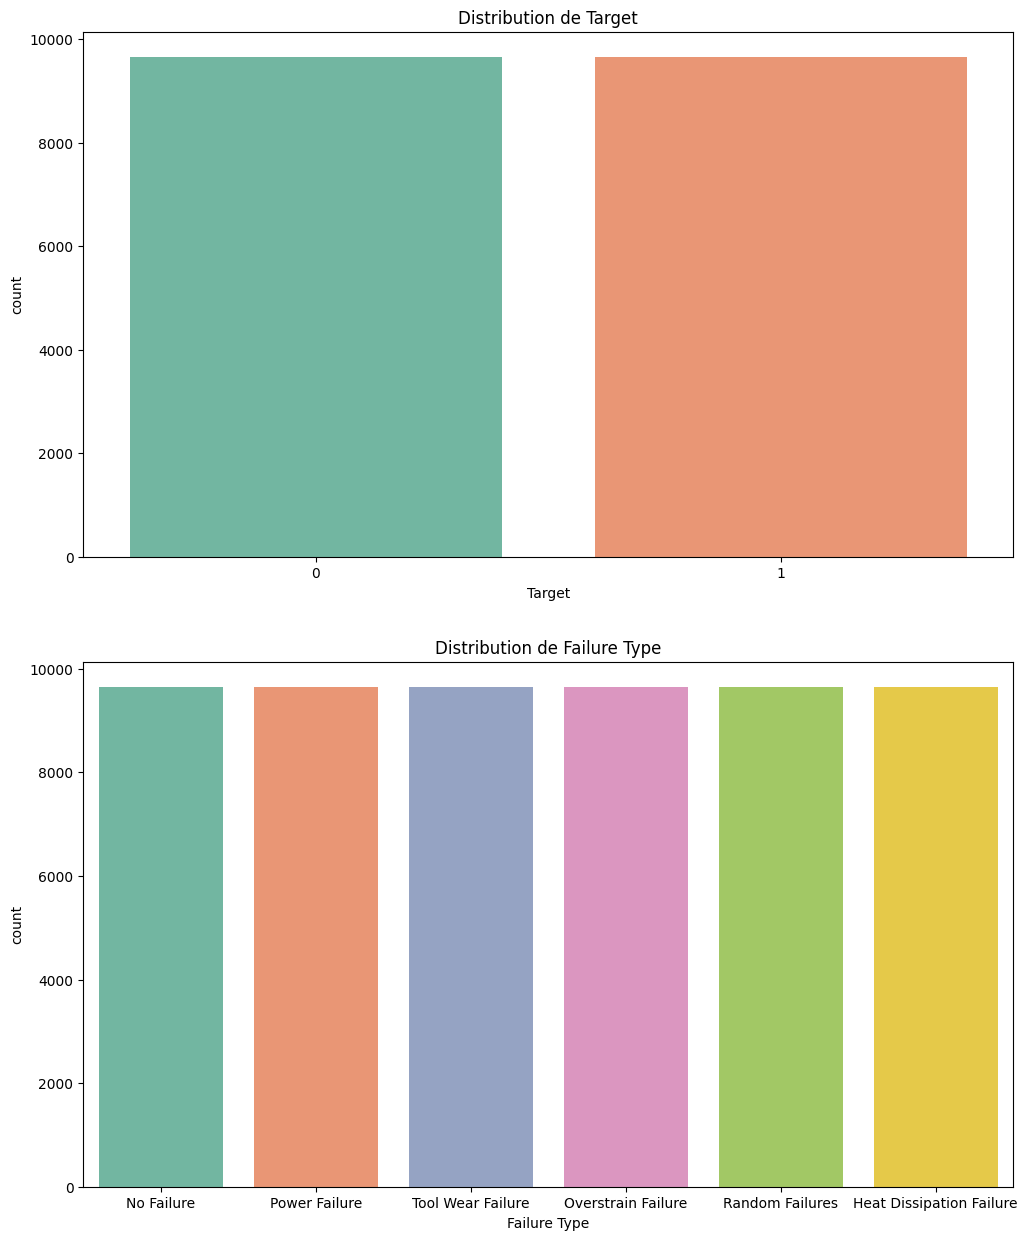

In [750]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 15))

sns.countplot(x=y_resampled_binaire, ax=axes[0], palette="Set2")
axes[0].set_title(f'Distribution de Target')

sns.countplot(x=y_resampled_multi,  ax=axes[1], palette="Set2")
axes[1].set_title(f'Distribution de Failure Type')
plt.show()

### 4. Sélection des Variables & entraînement des Modèles de Machine Learning
#### 4.1. Classification binaire

+ Selection de variable avec PCA

In [751]:
# Sélection des variables avec PCA
scaler = StandardScaler()
X_scaled_binaire = scaler.fit_transform(X_resampled_binaire)
pca = PCA()
pca.fit(X_scaled_binaire) 

PCA()

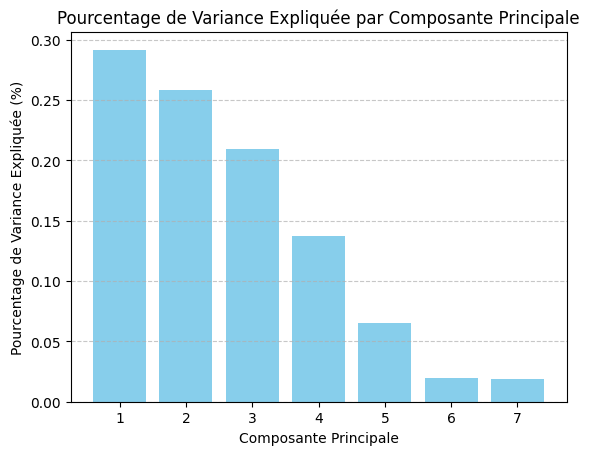

In [752]:
plt.figure()
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Composante Principale')
plt.ylabel('Pourcentage de Variance Expliquée (%)')
plt.title('Pourcentage de Variance Expliquée par Composante Principale')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

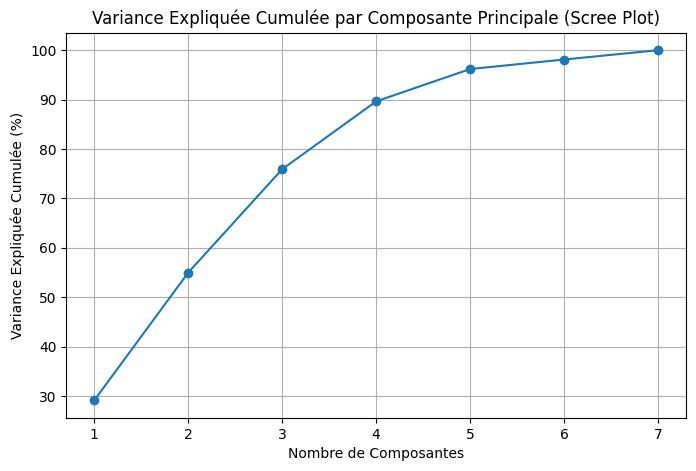

In [753]:
# Variance expliquée cumulée
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_) * 100  # Convertir en pourcentage

# Tracé de la variance expliquée cumulée pour chaque composante
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Expliquée Cumulée (%)')
plt.title('Variance Expliquée Cumulée par Composante Principale (Scree Plot)')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.grid(True)
plt.show()

In [754]:
pca = PCA(n_components=5)
X_pca_binaire = pca.fit_transform(X_scaled_binaire)

In [755]:
# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X_pca_binaire, y_resampled_binaire, test_size=0.2, random_state=42)

In [756]:
# Initialisation des modèles
log_reg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=5)

# Entraînement des modèles
log_reg.fit(X_train, y_train)
knn.fit(X_train, y_train)

# 4. Prédictions
y_pred_log_reg = log_reg.predict(X_test)
y_pred_knn = knn.predict(X_test)

In [757]:
# 5. Évaluation des modèles
print("\n=== Régression Logistique ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.2f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_log_reg))
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_log_reg))



=== Régression Logistique ===
Accuracy: 0.86

Rapport de classification :
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1934
           1       0.87      0.85      0.86      1931

    accuracy                           0.86      3865
   macro avg       0.86      0.86      0.86      3865
weighted avg       0.86      0.86      0.86      3865


Matrice de confusion :
[[1692  242]
 [ 291 1640]]


In [758]:
print("\n=== KNN ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.2f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_knn))
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_knn))


=== KNN ===
Accuracy: 0.95

Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1934
           1       0.92      0.98      0.95      1931

    accuracy                           0.95      3865
   macro avg       0.95      0.95      0.95      3865
weighted avg       0.95      0.95      0.95      3865


Matrice de confusion :
[[1780  154]
 [  45 1886]]


In [759]:
from sklearn.metrics import f1_score

def calculate_f1_multiclass(y_true, y_pred):
    return f1_score(y_true, y_pred)


# Calcul des métriques
metrics = {
    "Model": ["Logistic Regression", "KNN"],
    "F1-Score": [calculate_f1_multiclass(y_test, y_pred_log_reg), calculate_f1_multiclass(y_test, y_pred_knn)],
    "Accuracy": [accuracy_score(y_test, y_pred_log_reg), accuracy_score(y_test, y_pred_knn)],
    "Precision": [precision_score(y_test, y_pred_log_reg, average="macro"), precision_score(y_test, y_pred_knn, average="macro")],
    "Recall": [recall_score(y_test, y_pred_log_reg, average="macro"), recall_score(y_test, y_pred_knn, average="macro")],
}


# Affichage sous forme de DataFrame
df_metrics = pd.DataFrame(metrics)
print(df_metrics)

                 Model  F1-Score  Accuracy  Precision    Recall
0  Logistic Regression  0.860215  0.862096   0.862333  0.862086
1                  KNN  0.949887  0.948512   0.949926  0.948534


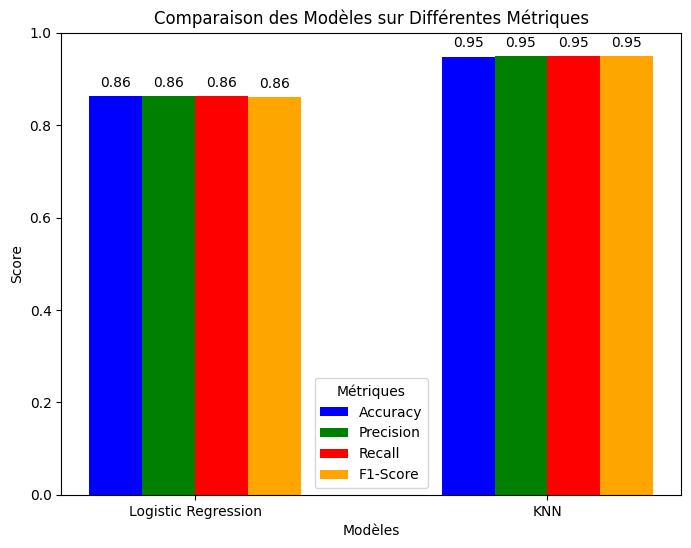

In [760]:
import matplotlib.pyplot as plt
import numpy as np

# Extraction des valeurs
models = metrics["Model"]
accuracy = metrics["Accuracy"]
precision = metrics["Precision"]
recall = metrics["Recall"]
f1_score = metrics["F1-Score"]

# Paramètres du graphique
x = np.arange(len(models))  # Indices des modèles
width = 0.15  # Largeur des barres

fig, ax = plt.subplots(figsize=(8, 6))

# Tracer les barres pour chaque métrique
ax.bar(x - 1.5*width, accuracy, width, label="Accuracy", color='blue')
ax.bar(x - 0.5*width, precision, width, label="Precision", color='green')
ax.bar(x + 0.5*width, recall, width, label="Recall", color='red')
ax.bar(x + 1.5*width, f1_score, width, label="F1-Score", color='orange')

# Ajout des labels et du titre
ax.set_xlabel("Modèles")
ax.set_ylabel("Score")
ax.set_title("Comparaison des Modèles sur Différentes Métriques")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend(title="Métriques")

# Ajout des valeurs sur les barres
for i in range(len(models)):
    ax.text(x[i] - 1.5*width, accuracy[i] + 0.02, f"{accuracy[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] - 0.5*width, precision[i] + 0.02, f"{precision[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] + 0.5*width, recall[i] + 0.02, f"{recall[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] + 1.5*width, f1_score[i] + 0.02, f"{f1_score[i]:.2f}", ha='center', fontsize=10)

# Affichage du graphique
plt.show()


+ Selection de toutes le variables caractéristiques

In [761]:
# Séparation des données
X_scaled_binaire = scaler.fit_transform(X_resampled_binaire)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_binaire, y_resampled_binaire, test_size=0.2, random_state=42)

# Entrainer le modèle

log_reg.fit(X_train, y_train)
knn.fit(X_train, y_train)


y_pred_log_reg = log_reg.predict(X_test)
y_pred_knn = knn.predict(X_test)

In [762]:
from sklearn.metrics import f1_score




# Calcul des métriques
metrics = {
    "Model": ["Logistic Regression", "KNN"],
    "F1-Score": [calculate_f1_multiclass(y_test, y_pred_log_reg), calculate_f1_multiclass(y_test, y_pred_knn)],
    "Accuracy": [accuracy_score(y_test, y_pred_log_reg), accuracy_score(y_test, y_pred_knn)],
    "Precision": [precision_score(y_test, y_pred_log_reg, average="macro"), precision_score(y_test, y_pred_knn, average="macro")],
    "Recall": [recall_score(y_test, y_pred_log_reg, average="macro"), recall_score(y_test, y_pred_knn, average="macro")],
}


# Affichage sous forme de DataFrame
df_metrics = pd.DataFrame(metrics)
print(df_metrics)

                 Model  F1-Score  Accuracy  Precision    Recall
0  Logistic Regression  0.877948  0.878137   0.878138  0.878136
1                  KNN  0.960993  0.960155   0.961054  0.960172


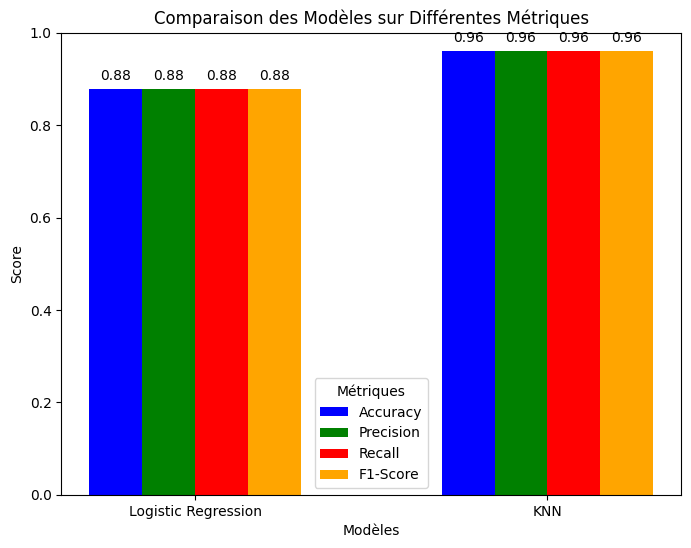

In [763]:
import matplotlib.pyplot as plt
import numpy as np

# Extraction des valeurs
models = metrics["Model"]
accuracy = metrics["Accuracy"]
precision = metrics["Precision"]
recall = metrics["Recall"]
f1_score = metrics["F1-Score"]

# Paramètres du graphique
x = np.arange(len(models))  # Indices des modèles
width = 0.15  # Largeur des barres

fig, ax = plt.subplots(figsize=(8, 6))

# Tracer les barres pour chaque métrique
ax.bar(x - 1.5*width, accuracy, width, label="Accuracy", color='blue')
ax.bar(x - 0.5*width, precision, width, label="Precision", color='green')
ax.bar(x + 0.5*width, recall, width, label="Recall", color='red')
ax.bar(x + 1.5*width, f1_score, width, label="F1-Score", color='orange')

# Ajout des labels et du titre
ax.set_xlabel("Modèles")
ax.set_ylabel("Score")
ax.set_title("Comparaison des Modèles sur Différentes Métriques")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend(title="Métriques")

# Ajout des valeurs sur les barres
for i in range(len(models)):
    ax.text(x[i] - 1.5*width, accuracy[i] + 0.02, f"{accuracy[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] - 0.5*width, precision[i] + 0.02, f"{precision[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] + 0.5*width, recall[i] + 0.02, f"{recall[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] + 1.5*width, f1_score[i] + 0.02, f"{f1_score[i]:.2f}", ha='center', fontsize=10)

# Affichage du graphique
plt.show()


#### 4.2. Classification multi-classes

+ Selection des variables avec PCA

In [764]:
# Sélection des variables avec PCA
X_scaled_multi = scaler.fit_transform(X_resampled_multi)
pca = PCA()
pca.fit(X_scaled_multi) 

PCA()

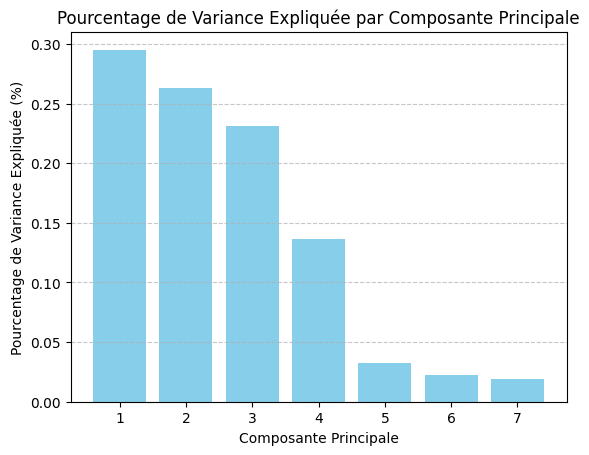

In [765]:
plt.figure()
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Composante Principale')
plt.ylabel('Pourcentage de Variance Expliquée (%)')
plt.title('Pourcentage de Variance Expliquée par Composante Principale')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

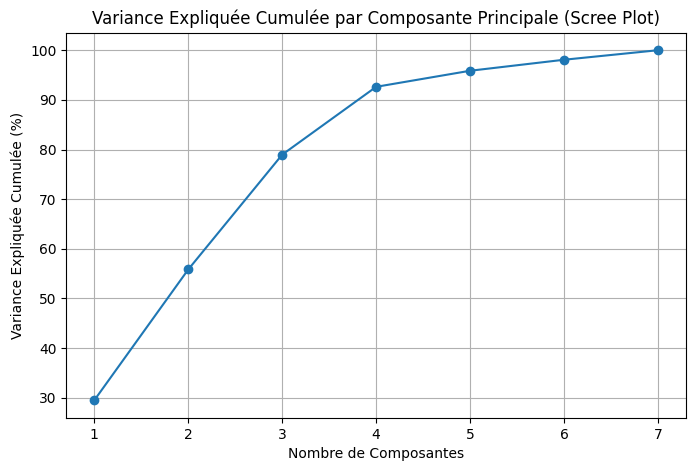

In [766]:
# Variance expliquée cumulée
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_) * 100  # Convertir en pourcentage

# Tracé de la variance expliquée cumulée pour chaque composante
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Expliquée Cumulée (%)')
plt.title('Variance Expliquée Cumulée par Composante Principale (Scree Plot)')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.grid(True)
plt.show()

In [767]:
pca = PCA(n_components=5)
X_pca_multi = pca.fit_transform(X_scaled_multi)

In [768]:
# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X_pca_multi, y_resampled_multi, test_size=0.2, random_state=42)

In [769]:
# Initialisation des modèles# Initialiser le modèle Softmax
log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=5)


# Entraînement des modèles
log_reg.fit(X_train, y_train)
knn.fit(X_train, y_train)

c:\Users\atsou\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


KNeighborsClassifier()

In [770]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Prédictions
y_pred_log = log_reg.predict(X_test)
y_pred_knn = knn.predict(X_test)

def calculate_f1_from_precision_recall(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

# Calcul des métriques
metrics = {
    "Model": ["Logistic Regression", "KNN"],
    "Accuracy": [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_knn)],
    "Precision": [precision_score(y_test, y_pred_log, average="macro"), precision_score(y_test, y_pred_knn, average="macro")],
    "Recall": [recall_score(y_test, y_pred_log, average="macro"), recall_score(y_test, y_pred_knn, average="macro")],
    "F1-Score": [
        calculate_f1_from_precision_recall(
            precision_score(y_test, y_pred_log, average="macro"),
            recall_score(y_test, y_pred_log, average="macro")
        ),
        calculate_f1_from_precision_recall(
            precision_score(y_test, y_pred_knn, average="macro"),
            recall_score(y_test, y_pred_knn, average="macro")
        ),
    ],
}

# Affichage sous forme de DataFrame
df_metrics = pd.DataFrame(metrics)
print(df_metrics)


                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.703099   0.699956  0.703215  0.701582
1                  KNN  0.990762   0.990827  0.990911  0.990869


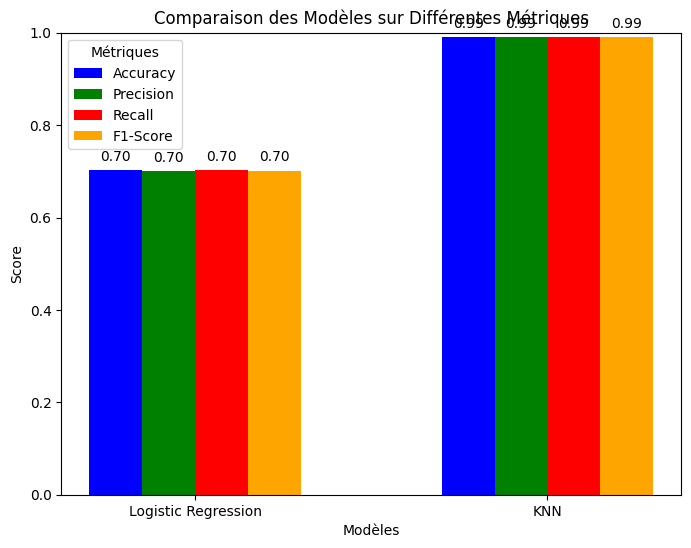

In [771]:
import matplotlib.pyplot as plt
import numpy as np

# Extraction des valeurs
models = metrics["Model"]
accuracy = metrics["Accuracy"]
precision = metrics["Precision"]
recall = metrics["Recall"]
f1_score = metrics["F1-Score"]

# Paramètres du graphique
x = np.arange(len(models))  # Indices des modèles
width = 0.15  # Largeur des barres

fig, ax = plt.subplots(figsize=(8, 6))

# Tracer les barres pour chaque métrique
ax.bar(x - 1.5*width, accuracy, width, label="Accuracy", color='blue')
ax.bar(x - 0.5*width, precision, width, label="Precision", color='green')
ax.bar(x + 0.5*width, recall, width, label="Recall", color='red')
ax.bar(x + 1.5*width, f1_score, width, label="F1-Score", color='orange')

# Ajout des labels et du titre
ax.set_xlabel("Modèles")
ax.set_ylabel("Score")
ax.set_title("Comparaison des Modèles sur Différentes Métriques")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend(title="Métriques")

# Ajout des valeurs sur les barres
for i in range(len(models)):
    ax.text(x[i] - 1.5*width, accuracy[i] + 0.02, f"{accuracy[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] - 0.5*width, precision[i] + 0.02, f"{precision[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] + 0.5*width, recall[i] + 0.02, f"{recall[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] + 1.5*width, f1_score[i] + 0.02, f"{f1_score[i]:.2f}", ha='center', fontsize=10)

# Affichage du graphique
plt.show()


+ Selection de toutes le variables

In [772]:
# Separation des données
X_train, X_test, y_train, y_test = train_test_split(X_scaled_multi, y_resampled_multi, test_size=0.2, random_state=42)

In [773]:
# Entraînement des modèles
log_reg.fit(X_train, y_train)
knn.fit(X_train, y_train)

c:\Users\atsou\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


KNeighborsClassifier()

In [774]:
# Prédictions
y_pred_log = log_reg.predict(X_test)
y_pred_knn = knn.predict(X_test)

from sklearn.metrics import f1_score

def calculate_f1_multiclass(y_true, y_pred, average='macro'):
    return f1_score(y_true, y_pred, average=average)


# Calcul des métriques
metrics = {
    "Model": ["Logistic Regression", "KNN"],
    "F1-Score": [calculate_f1_multiclass(y_test, y_pred_log), calculate_f1_multiclass(y_test, y_pred_knn)],
    "Accuracy": [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_knn)],
    "Precision": [precision_score(y_test, y_pred_log, average="macro"), precision_score(y_test, y_pred_knn, average="macro")],
    "Recall": [recall_score(y_test, y_pred_log, average="macro"), recall_score(y_test, y_pred_knn, average="macro")],
}


# Affichage sous forme de DataFrame
df_metrics = pd.DataFrame(metrics)
print(df_metrics)


                 Model  F1-Score  Accuracy  Precision    Recall
0  Logistic Regression  0.855721   0.85850   0.855468  0.859060
1                  KNN  0.992210   0.99223   0.992289  0.992355


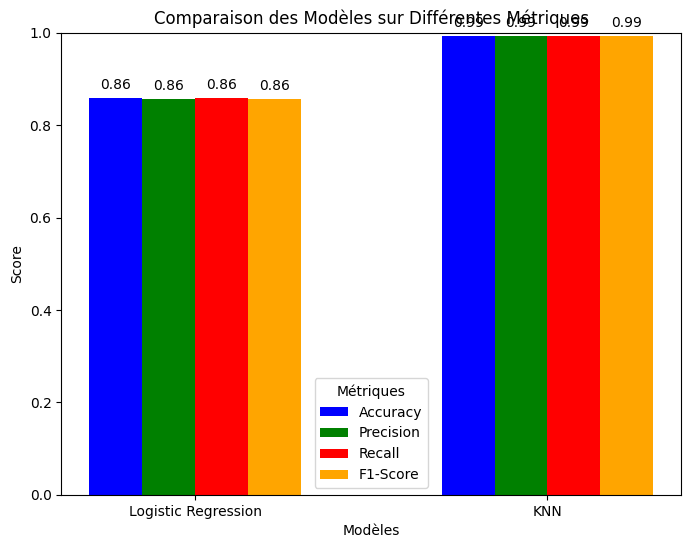

In [775]:
import matplotlib.pyplot as plt
import numpy as np

# Extraction des valeurs
models = metrics["Model"]
accuracy = metrics["Accuracy"]
precision = metrics["Precision"]
recall = metrics["Recall"]
f1_score = metrics["F1-Score"]

# Paramètres du graphique
x = np.arange(len(models))  # Indices des modèles
width = 0.15  # Largeur des barres

fig, ax = plt.subplots(figsize=(8, 6))

# Tracer les barres pour chaque métrique
ax.bar(x - 1.5*width, accuracy, width, label="Accuracy", color='blue')
ax.bar(x - 0.5*width, precision, width, label="Precision", color='green')
ax.bar(x + 0.5*width, recall, width, label="Recall", color='red')
ax.bar(x + 1.5*width, f1_score, width, label="F1-Score", color='orange')

# Ajout des labels et du titre
ax.set_xlabel("Modèles")
ax.set_ylabel("Score")
ax.set_title("Comparaison des Modèles sur Différentes Métriques")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend(title="Métriques")

# Ajout des valeurs sur les barres
for i in range(len(models)):
    ax.text(x[i] - 1.5*width, accuracy[i] + 0.02, f"{accuracy[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] - 0.5*width, precision[i] + 0.02, f"{precision[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] + 0.5*width, recall[i] + 0.02, f"{recall[i]:.2f}", ha='center', fontsize=10)
    ax.text(x[i] + 1.5*width, f1_score[i] + 0.02, f"{f1_score[i]:.2f}", ha='center', fontsize=10)

# Affichage du graphique
plt.show()


### 5. Analyse des Résultats et Améliorations

+ On remarque que le KNN presente la meilleur performance dans les deux classifications avec ces differentes approches de selection de variables caractéristiques ( PCA, selection de toutes les variables )

+ On pourra explorer d'autres approches de selections de variables pour ameliorer les performances du model ou varier le valeur du nombre de voisins ( pour KNN )